In [1]:
import fsspec
import cf_xarray
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo='s3://nextgen-dmac-cloud-ingest/nos/cbofs/nos.cbofs.fields.best.nc.zarr', remote_protocol='s3', remote_options={'anon':True}, target_protocol='s3', target_options={'anon':True})
m = fs.get_mapper("") 

ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), 
                      chunks={})
ds

<xarray.Dataset>
Dimensions:         (ocean_time: 780, tracer: 3, s_rho: 20, s_w: 21,
                     boundary: 4, eta_rho: 291, xi_rho: 332, eta_psi: 290,
                     xi_psi: 331, eta_u: 291, xi_u: 331, eta_v: 290, xi_v: 332)
Coordinates:
    lat_psi         (eta_psi, xi_psi) float64 dask.array<chunksize=(290, 331), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
    lat_u           (eta_u, xi_u) float64 dask.array<chunksize=(291, 331), meta=np.ndarray>
    lat_v           (eta_v, xi_v) float64 dask.array<chunksize=(290, 332), meta=np.ndarray>
    lon_psi         (eta_psi, xi_psi) float64 dask.array<chunksize=(290, 331), meta=np.ndarray>
    lon_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
    lon_u           (eta_u, xi_u) float64 dask.array<chunksize=(291, 331), meta=np.ndarray>
    lon_v           (eta_v, xi_v) float64 dask.array<chunksize=(290, 332), meta=np.ndarray>
  * ocean_time      (ocean_time) datetime64[ns] 2023-09-03T01:00:00 ... 2023-...
  * s_rho           (s_rho) float64 -0.975 -0.925 -0.875 ... -0.075 -0.025
  * s_w             (s_w) float64 -1.0 -0.95 -0.9 -0.85 ... -0.15 -0.1 -0.05 0.0
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_psi,
                                xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/97)
    Akk_bak         (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akp_bak         (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akt_bak         (ocean_time, tracer) float64 dask.array<chunksize=(1, 3), meta=np.ndarray>
    Akv_bak         (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    BioIter         (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Charnok_alpha   (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ...              ...
    theta_s         (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    u               (ocean_time, s_rho, eta_u, xi_u) float32 dask.array<chunksize=(1, 10, 146, 166), meta=np.ndarray>
    v               (ocean_time, s_rho, eta_v, xi_v) float32 dask.array<chunksize=(1, 10, 145, 166), meta=np.ndarray>
    w               (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 11, 146, 166), meta=np.ndarray>
    xl              (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    zeta            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 291, 332), meta=np.ndarray>
Attributes: (12/36)
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ANA_BSFLUX, AN...
    Conventions:       CF-1.4, SGRID-0.3
    NLM_LBC:           \nEDGE:    WEST   SOUTH  EAST   NORTH  \nzeta:    Clo ...
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_ra...
    bio_file:          ROMS/Nonlinear/Biology/hypoxia_srm.h
    ...                ...
    svn_url:           
    tide_file:         nos.cbofs.roms.tides.nc
    tiling:            008x016
    title:             cbofs forecast RUN in operational mode
    type:              ROMS/TOMS history file
    var_info:          varinfo.yaml

/var/folders/b2/s20v34y16hg9263q_zf2y1740000gn/T/ipykernel_53363/3481027991.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon, lat, salt, edgecolor='none')


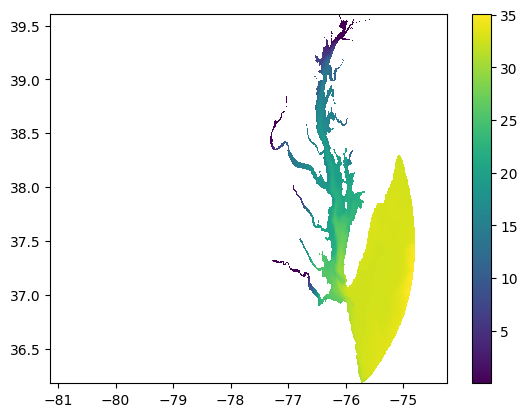

In [4]:
ds_sel = ds.cf.isel(time=0)
mask = ds_sel.mask_rho.values
salt = ds_sel.salt.cf.isel(vertical=0).values
lat = ds_sel.lat_rho.values
lon = ds_sel.lon_rho.values

# https://github.com/ioos/Cloud-Sandbox/blob/main/cloudflow/plotting/plot_roms.py
# Apply mask
salt = np.ma.masked_where(mask == 0, salt)

# pcolor uses surrounding points, if any are masked, mask this cell
#   see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolor.html
salt[:-1,:] = np.ma.masked_where(mask[1:,:] == 0, salt[:-1,:])
salt[:,:-1] = np.ma.masked_where(mask[:,1:] == 0, salt[:,:-1])
salt[1:,:] = np.ma.masked_where(mask[:-1,:] == 0, salt[1:,:])
salt[:,1:] = np.ma.masked_where(mask[:,:-1] == 0, salt[:,1:])

plt.pcolormesh(lon, lat, salt, edgecolor='none')
plt.colorbar()